<a href="https://colab.research.google.com/github/minhducvo04/PyTorch-models/blob/main/PyTorch_Finding_The_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch custom datasets

We've used some datasets with PyTorch before

But how do we get our own data into PyTorch?

One of the ways to do so is via : Custom Datasets

## Domain libraries:
Depend on what type of data you want to work with (vision, text, video,etc.). You'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.
 

## Setting up

## Importing libraries

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor 
from torchvision import datasets
from torch.utils.data import DataLoader

from typing import Tuple, Dict, List

from torch.utils.data import Dataset

from tqdm.auto import tqdm

from timeit import default_timer as timer

## Set up device

In [ ]:
# Device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Fri Dec 30 19:03:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    53W / 400W |  39264MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set up timer

In [ ]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

## Get data
Our datasets is a subset of the Food101 dataset

Food101 starts 101 different classes of food and 1000 images per class (750 training and 250 testing).

Our datasets start with 3 classes of food and only 10% of the images (75 training and 25 testing) 

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary

The whole point is to speed up how fast you can experiment

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path/ "Pizza_steak_sushi"

# If the image folder doesn't exist, download it...
if image_path.is_dir():
  print (f" {image_path} directory already exists... skipping download")
else:
  print (f" {image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak, and sushi datasets
with open(data_path/ "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print ("Downloading pizza, steak, suhsi data..." )
  f.write (request.content)

# Unzip the file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

 data/Pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, and sushi data...


## Becoming one with the data (Data preparation and Data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/Pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/Pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/Pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/Pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/Pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/Pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/Pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/Pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/Pizza_steak_sushi/train/sushi'.


In [ ]:
# Setup train and test paths
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/Pizza_steak_sushi/train'),
 PosixPath('data/Pizza_steak_sushi/test'))

In [ ]:
from torchvision.datasets import ImageFolder

## Visualize image

Let's write some code to:
1. Get all of the image path
2. Pick a random one
3. Get the image class names using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with Python's PIL
5. We'll show the image and print metadata

In [ ]:
import random
from PIL import Image

data/Pizza_steak_sushi/test/sushi/1680893.jpg
sushi
Random image path: data/Pizza_steak_sushi/test/sushi/1680893.jpg
Image class: sushi
Image height: 512
Image width: 512
Num of layers: 3


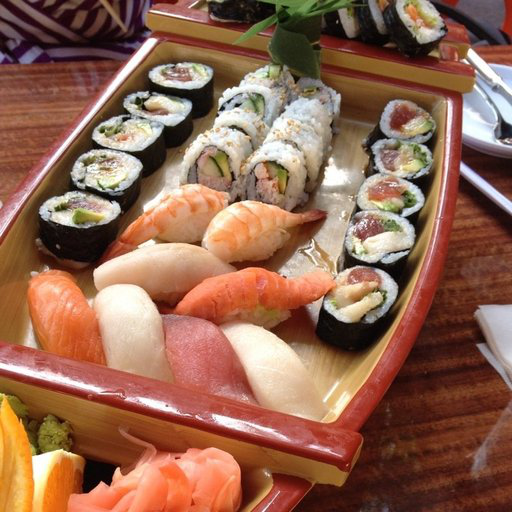

In [ ]:
# Set seed 
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from class names (the class name is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Num of layers: {img.layers}")
img

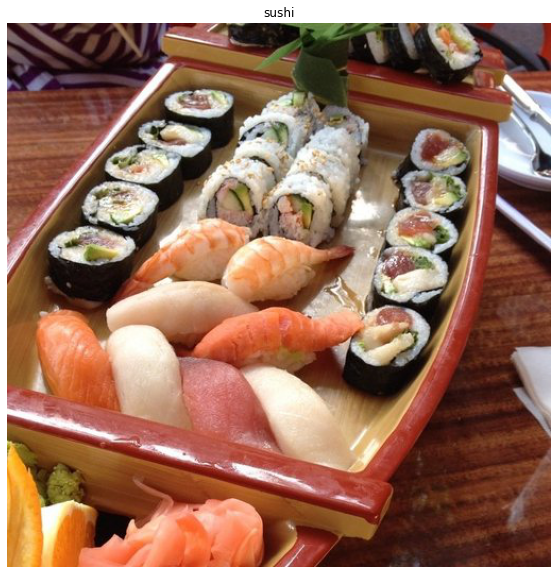

In [ ]:
# Turn image into array
img_as_array = np.asarray(img)
plt.figure(figsize=(10,10))
plt.imshow(img_as_array)
plt.axis(False);
plt.title(f"{image_class}");

In [ ]:
img_as_array.shape

(512, 512, 3)

In [ ]:
img_as_array

array([[[ 34,   8,   9],
        [ 36,  10,  11],
        [ 40,  11,  13],
        ...,
        [137,  29,  16],
        [141,  31,  16],
        [140,  30,  15]],

       [[ 37,  11,  12],
        [ 37,   8,  10],
        [ 36,   7,   9],
        ...,
        [137,  29,  16],
        [141,  31,  16],
        [140,  30,  15]],

       [[ 45,  17,  16],
        [ 39,  10,  12],
        [ 34,   5,   7],
        ...,
        [136,  28,  15],
        [141,  31,  18],
        [140,  30,  15]],

       ...,

       [[221, 144,  40],
        [218, 141,  37],
        [218, 140,  40],
        ...,
        [ 66,  28,  19],
        [ 64,  26,  15],
        [ 60,  22,  11]],

       [[219, 142,  36],
        [217, 140,  36],
        [216, 138,  37],
        ...,
        [ 65,  27,  18],
        [ 66,  28,  17],
        [ 65,  27,  16]],

       [[218, 141,  35],
        [215, 138,  32],
        [215, 137,  36],
        ...,
        [ 67,  29,  20],
        [ 70,  34,  22],
        [ 72,  36,  24]]

## Transforming data
Before we can use our image data with PyTorch:
1. Turn our data into tensors (into numerical representation)
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` we'll call these `Dataset` and `DataLoader`

## Transforming data using `torchvision.transforms`
Transform help to get your data ready to be used with a model/ perform data augmentation

In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our shape into 64x64
    transforms.Resize(size=(64,64)),
    # Flip the image randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).dtype

torch.float32

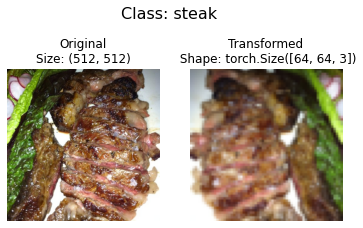

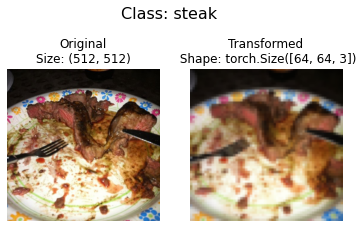

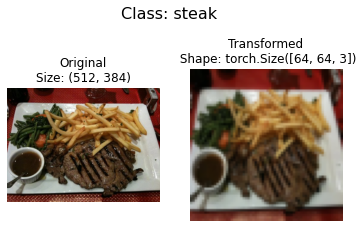

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images, transform it and then plots the original vs transformed ones
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot targeted image
      transformed_image=transform(f)
      transformed_image=transformed_image.permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n Shape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_path_list,data_transform,seed=None)

## Option 1: Loading images using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Using ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for data
                                  target_transform=None) # a transform for the label
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, 
                                  target_transform=None) 
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/Pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/Pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names 
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
train_data.samples[0]

('data/Pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# Index on the train_data Datasets to get one sample and label
img, label =  train_data[0][0], train_data[0][1]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

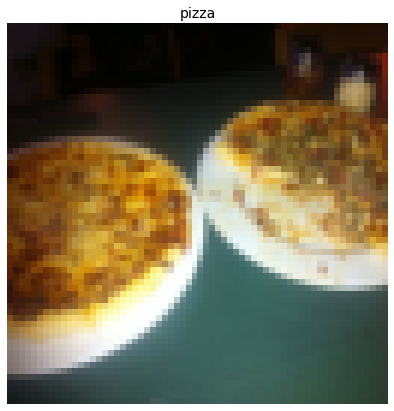

In [ ]:
# Rearrange the order dimension
img_permute = img.permute(1,2,0)

# Plot the image
plt.figure(figsize= (10, 7))
plt.imshow (img_permute)
plt.axis("off");
plt.title (class_names[label], fontsize=14);

## Turn Dataset into DataLoader
A `DataLoader` will helps to turn our data into iterables we can customize `batch_size` so our model can see `batch_size` model at a time

In [ ]:
os.cpu_count()

12

In [ ]:

# Turn train and test data into dataloader
BATCH_SIZE = 32 
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle = True)
test_dataloader=DataLoader(batch_size=BATCH_SIZE,
                           dataset=test_data,
                           num_workers=os.cpu_count(),
                           shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f6de0494610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6de04942b0>)

In [ ]:
img, label = next(iter(train_dataloader))
img, label

(tensor([[[[0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0157, 0.0471],
           [0.0078, 0.0118, 0.0118,  ..., 0.0235, 0.0314, 0.0471],
           [0.0078, 0.0157, 0.0157,  ..., 0.0275, 0.0471, 0.0588],
           ...,
           [0.5608, 0.6353, 0.7412,  ..., 0.0196, 0.0235, 0.0235],
           [0.3961, 0.5529, 0.6275,  ..., 0.0196, 0.0235, 0.0196],
           [0.1412, 0.3333, 0.5529,  ..., 0.0196, 0.0157, 0.0157]],
 
          [[0.0157, 0.0157, 0.0157,  ..., 0.0588, 0.0471, 0.0667],
           [0.0157, 0.0196, 0.0196,  ..., 0.0588, 0.0627, 0.0706],
           [0.0157, 0.0235, 0.0235,  ..., 0.0588, 0.0706, 0.0824],
           ...,
           [0.5020, 0.4980, 0.5451,  ..., 0.0157, 0.0196, 0.0196],
           [0.3686, 0.4941, 0.4980,  ..., 0.0157, 0.0196, 0.0157],
           [0.1216, 0.3098, 0.5020,  ..., 0.0157, 0.0118, 0.0118]],
 
          [[0.0118, 0.0118, 0.0118,  ..., 0.0745, 0.0510, 0.0667],
           [0.0118, 0.0157, 0.0157,  ..., 0.0667, 0.0588, 0.0588],
           [0.0039, 0.01

In [ ]:
print (f"Image shape: {img.shape} -> [batch_size, color _channels, height, width]")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color _channels, height, width]


## Option 2: Loading Image Data with a Custom `Dataset`
1. Want to be able to load image from file
2. Want to get class names from the Dataset
3. Want to get classes as dictionary from Dataset

Pros:
* Can create `Dataset` out of everything
* Not limited to PyTorch pre-built `Dataset` funtions

Cons
* A lot of those created `Dataset` will not work
* We often have to write more code -> easier to get errors and performance issues 

In [ ]:
# Instance of torchvision.datasets.ImageLoader()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

##Create a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to tranverse a target directory (ideally the directory is in the standard image classification format)
2. Raise an error if the class names are not found (if this happens, there is something wrong with the directory structure)
3. Turn the class names into a dict and a list, then return them

In [ ]:
# Set up path for target directory
target_directory = train_dir
target_directory

PosixPath('data/Pizza_steak_sushi/train')

In [ ]:
# Get class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

In [ ]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """
  Finds the class folder names in a target directory
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  # 3. Create a dictionary of index labels (computer prefer numbers)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  
  return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom `Dataset` to replicate `ImageFolder`
To create our own custom dataset, we want to:
1. Subclass `nn.utils.data.Dataset`
2. Init our subclasses with a target directory (the directory we'd like to get our data from) as well as a transform if we want to transform our data
3. Create a several attributes:
* paths - path of our images 
* transform - transform we want to use
* classes - a list of target classes
* class_to_idx - a dict of target classes mapped with integer labels
4. Create a function to `load_images()`, this function is to open an image
5. Overwrite `__len__()` method to return the size of our dataset
6. Overwrite `__getitem__()` method to return a given samples when passed an index

In [ ]:
# Write a custom dataset class 
from torch.utils.data import Dataset
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes, Get all of the image paths
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    
    # Set up transform
    self.transform = transform

    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Open image via a path and return it
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """
    Return the total number of samples
    """
    return len(self.paths)

  # 6. Overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Return one sample of data, data and label (X,y)
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

  # Transform it if necessary
    if self.transform:
      return self.transform(img), class_idx # Return data, label (X,y)
    else:
      return img, class_idx # Return untransform image and label

In [ ]:
# Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f6de030af40>,
 <__main__.ImageFolderCustom at 0x7f6de0411100>)

In [ ]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
train_data.classes == train_data_custom.classes

True

## Create a function to display random images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize 
2. To prevent displays out of hand, let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Set up a matplotlib plot.
6. Loop through the random sample indexes and plot them.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images (dataset:torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int = 10,
                           display_shape: bool = True,
                           seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print (f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  # 5. Set up plot
  plt.figure(figsize=(20,12))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # From [C,H,W] -> [H,W,C]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False);
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

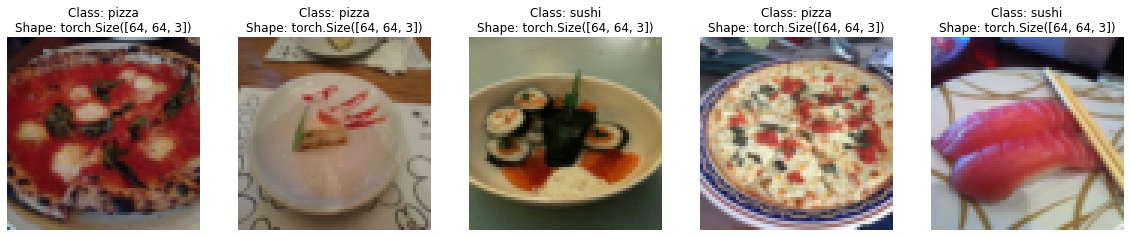

In [ ]:
# Display the random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      classes=class_names,
                      n = 5,
                      seed = None)

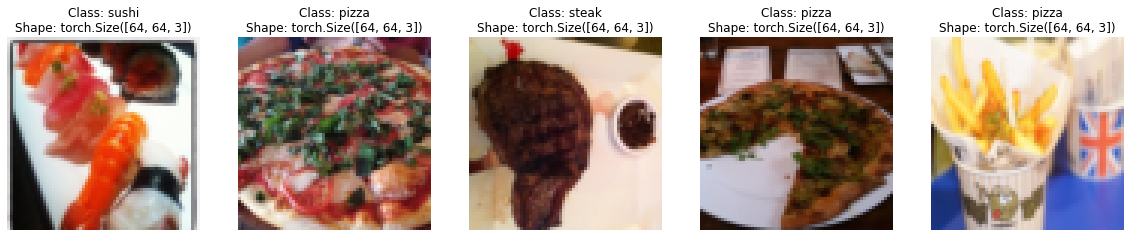

In [ ]:
# Display the random images from the ImageFolderCustom created Dataset
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n = 5,
                      seed = None)

## Turn custom loaded images into `DataLoader`

In [ ]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=0)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=0)
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f6d93fb4f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6d93fb4f40>)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other form of transform (data augmentation)
Is the the process of artificially adding diversity to your training data

In case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generizable to unseen data

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to the state of the art level

In [ ]:
# Let look at trivial augment
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [ ]:
# Get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/Pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/Pizza_steak_sushi/test/steak/3424937.jpg')]

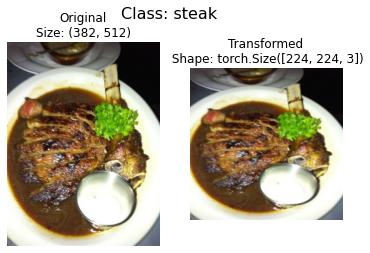

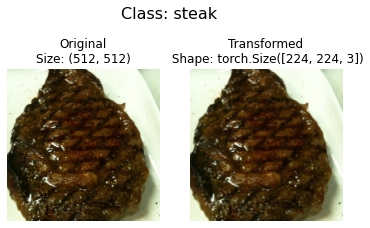

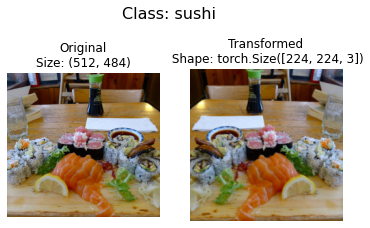

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n = 3,
    seed = None
)

# Model 0: TinyVGG without data augmentation
Let's replicate the VGG architecture from the CNN explainer website

## Create transforms and loading data for Model 0

In [ ]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [ ]:
# Load data
train_data_simple = ImageFolder(root=train_dir,
                                transform=simple_transform)
test_data_simple = ImageFolder(root=test_dir,
                                transform=simple_transform)
train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/Pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/Pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [ ]:
# Turn the datasets into dataloaders

# Set up batch size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
RESOLUTION = 512

# Create dataloader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f6d93de4c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6d93de49a0>)

In [ ]:
a = torch.tensor([10/4])
torch.round(a)

tensor([2.])

## Create TinyVGG

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               resolution: int) -> None:
    super().__init__()
    self.__resolution__ = torch.round(torch.tensor([resolution*resolution/64]))[0].int() if resolution else 16
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
        
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 9 * 121,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.classifier(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(class_names),
                  resolution=512).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), pad

## Try to pass through the model a single input 

In [ ]:
# Get a single image batch
batch_image, batch_label = next(iter(train_dataloader_simple))
batch_image.shape, batch_label.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(batch_image.to(device))

tensor([[-0.0093, -0.0124, -0.0204],
        [-0.0093, -0.0123, -0.0203],
        [-0.0091, -0.0123, -0.0204],
        [-0.0093, -0.0123, -0.0204],
        [-0.0093, -0.0125, -0.0203],
        [-0.0092, -0.0124, -0.0203],
        [-0.0093, -0.0124, -0.0203],
        [-0.0093, -0.0123, -0.0202],
        [-0.0093, -0.0124, -0.0204],
        [-0.0093, -0.0124, -0.0204],
        [-0.0093, -0.0124, -0.0203],
        [-0.0094, -0.0123, -0.0204],
        [-0.0091, -0.0122, -0.0203],
        [-0.0092, -0.0123, -0.0203],
        [-0.0092, -0.0123, -0.0203],
        [-0.0092, -0.0123, -0.0203],
        [-0.0092, -0.0124, -0.0203],
        [-0.0091, -0.0124, -0.0204],
        [-0.0092, -0.0123, -0.0204],
        [-0.0092, -0.0123, -0.0203],
        [-0.0093, -0.0124, -0.0203],
        [-0.0094, -0.0124, -0.0204],
        [-0.0092, -0.0124, -0.0204],
        [-0.0093, -0.0123, -0.0204],
        [-0.0091, -0.0123, -0.0204],
        [-0.0093, -0.0124, -0.0205],
        [-0.0093, -0.0124, -0.0203],
 

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0,input_size=[1,3,512,512])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 64, 257, 257]         --
│    └─Conv2d: 2-1                       [1, 64, 513, 513]         832
│    └─ReLU: 2-2                         [1, 64, 513, 513]         --
│    └─Conv2d: 2-3                       [1, 64, 514, 514]         16,448
│    └─ReLU: 2-4                         [1, 64, 514, 514]         --
│    └─MaxPool2d: 2-5                    [1, 64, 257, 257]         --
├─Sequential: 1-2                        [1, 64, 129, 129]         --
│    └─Conv2d: 2-6                       [1, 64, 258, 258]         16,448
│    └─ReLU: 2-7                         [1, 64, 258, 258]         --
│    └─Conv2d: 2-8                       [1, 64, 259, 259]         16,448
│    └─ReLU: 2-9                         [1, 64, 259, 259]         --
│    └─MaxPool2d: 2-10                   [1, 64, 129, 129]         --
├─

## Accuracy function

In [ ]:
 # Calculate accuracy - what percentage does the model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Create train and test function
* `train_step()` - takes in a model and dataloader and traines the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader



In [ ]:
# Create train_step
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Set up train loss and accuracy
  train_loss, train_acc = 0,0

  # Loop through batches in dataloader
  for batch, (X,y) in enumerate(dataloader):
    
    # Send data to device
    X,y=X.to(device),y.to(device)
    
    # 1. Forward pass
    y_pred = model(X)

    # 2. Set up loss function
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # 6. Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # 7. Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [ ]:
# Create test step
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device=device):
  # Put in eval mode
  model.eval()

  # Set up train loss and accuracy
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through batches in dataloader
    for batch, (X,y) in enumerate(dataloader):
      # Send data to device
      X,y=X.to(device),y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # 3. Calculate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # 4. Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc


## Create a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          optimizer=torch.optim.Optimizer,
          epochs: int = 20,
          device = device):
  
  # Set up optimizer
  change = 0
  best = 100
  model_save = model
  # 1. Create empty result dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  # 2. Loop through training and testing steps for a number of epoch
  for epoch in tqdm(range(epochs)):
    #optimizer=torch.optim.SGD(params=model.parameters(),
    #                              lr = learn)
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device = device)
    # 3. Print out what's happening
    print (f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.6f}')

    # 4. Update result dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    if results["test_loss"][-1] < best:
      model_save = model
      best = results["test_loss"][-1]
    
    #learn /= 1.2
  # 5. Return the result dictionary after loop
  return results, model_save

## Train and evaluate model 0

In [ ]:
# Set random seed
torch.manual_seed(42)

# Set number of epochs
EPOCH_NUM = 100

# Set time
TIME_NUM = 1


# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 8,
                  output_shape = len(train_data.classes),
                  resolution=512).to(device)

# Set up loss function
loss_fn = nn.CrossEntropyLoss()

# Start timer
start_time = timer()
learn = 0.001
for time in tqdm(range(TIME_NUM)):
  # Set up optimizer
  optimizer = torch.optim.Adam(params=model_0.parameters(),
                              lr=learn)

  # Train model 0
  model_2_results, model_0 = train(model=model_0,
                          train_dataloader=train_dataloader_simple,
                          test_dataloader=test_dataloader_simple,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=EPOCH_NUM,
                          device=device)
  
  # Set up optimizer
  optimizer = torch.optim.Adam(params=model_0.parameters(),
                              lr=0.00001)
  model_0_results, model_0 = train(model=model_0,
                          train_dataloader=train_dataloader_simple,
                          test_dataloader=test_dataloader_simple,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=EPOCH_NUM,
                          device=device)

# End the timer
end_time = timer()
print_train_time(start=start_time,end=end_time,device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2134 | Train acc: 0.2812 | Test loss: 1.1206 | Test acc: 0.260417
Epoch: 1 | Train loss: 1.0719 | Train acc: 0.4180 | Test loss: 1.2882 | Test acc: 0.197917
Epoch: 2 | Train loss: 1.1719 | Train acc: 0.2930 | Test loss: 1.0928 | Test acc: 0.197917
Epoch: 3 | Train loss: 1.1824 | Train acc: 0.2812 | Test loss: 1.0297 | Test acc: 0.541667
Epoch: 4 | Train loss: 1.1318 | Train acc: 0.2578 | Test loss: 1.1477 | Test acc: 0.187500
Epoch: 5 | Train loss: 1.0995 | Train acc: 0.2930 | Test loss: 1.0902 | Test acc: 0.197917
Epoch: 6 | Train loss: 1.0880 | Train acc: 0.3945 | Test loss: 1.0473 | Test acc: 0.541667
Epoch: 7 | Train loss: 1.1322 | Train acc: 0.2812 | Test loss: 1.0485 | Test acc: 0.541667
Epoch: 8 | Train loss: 1.1094 | Train acc: 0.2539 | Test loss: 1.0980 | Test acc: 0.197917
Epoch: 9 | Train loss: 1.1005 | Train acc: 0.3281 | Test loss: 1.0977 | Test acc: 0.442235
Epoch: 10 | Train loss: 1.0997 | Train acc: 0.3047 | Test loss: 1.0975 | Test acc: 0.35227

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4762 | Train acc: 0.8555 | Test loss: 1.1637 | Test acc: 0.432765
Epoch: 1 | Train loss: 0.3719 | Train acc: 0.8867 | Test loss: 1.1314 | Test acc: 0.454545
Epoch: 2 | Train loss: 0.4282 | Train acc: 0.8906 | Test loss: 1.1666 | Test acc: 0.495265
Epoch: 3 | Train loss: 0.4198 | Train acc: 0.8281 | Test loss: 1.1923 | Test acc: 0.383523
Epoch: 4 | Train loss: 0.5716 | Train acc: 0.7500 | Test loss: 1.0756 | Test acc: 0.516098
Epoch: 5 | Train loss: 0.3873 | Train acc: 0.8516 | Test loss: 1.3740 | Test acc: 0.412879
Epoch: 6 | Train loss: 0.4349 | Train acc: 0.8594 | Test loss: 1.2286 | Test acc: 0.433712
Epoch: 7 | Train loss: 0.4203 | Train acc: 0.8242 | Test loss: 1.2154 | Test acc: 0.402462
Epoch: 8 | Train loss: 0.4646 | Train acc: 0.7656 | Test loss: 1.2622 | Test acc: 0.483902
Epoch: 9 | Train loss: 0.4062 | Train acc: 0.8750 | Test loss: 1.1473 | Test acc: 0.465909
Epoch: 10 | Train loss: 0.3399 | Train acc: 0.8945 | Test loss: 1.1607 | Test acc: 0.46496

In [ ]:
test_loss, test_acc=test_step(model=model_0,
                      dataloader=train_dataloader_simple,
                      loss_fn=loss_fn,
                      device=device)
print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.6f}')


Test loss: 0.3336 | Test acc: 0.875000


In [ ]:
## Save the best model

from pathlib import Path
# Create model dictory path
MODEL_PATH = Path( "models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
# Create model save
MODEL_NAME = "PyTorch_Custom_Datasets.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/PyTorch_Custom_Datasets.pth')

In [ ]:
## Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/PyTorch_Custom_Datasets.pth


## Plot the loss curve of Model 0
A **loss curve** is a way of tracking your model's progress over time

In [ ]:
def plot_loss_curve(results:Dict[str, List[float]]):
  """
  Plot training curve of the results dictionary
  """
  # Get the loss values of the results dictionary (train and test)
  loss = results["train_loss"][1:]
  test_loss = results["test_loss"][1:]

  # Get the accuracy values of the results dictionary
  acc = results["train_acc"][1:]
  test_acc = results["test_acc"][1:]

  # Figure how many epoch there were
  epochs = range(len(results["train_loss"])-1)

  # Set up a plot
  plt.figure(figsize=(15,10))

  # Plot the loss
  plt.subplot(1,2,1);
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss");
  plt.xlabel("Epochs");
  plt.legend();

  # Plot the accuracy
  plt.subplot(1,2,2);
  plt.plot(epochs, acc, label = "train_accuracy")
  plt.plot(epochs, test_acc, label = "test_accuracy")
  plt.title("Accuracy");
  plt.xlabel("Epochs");
  plt.legend();

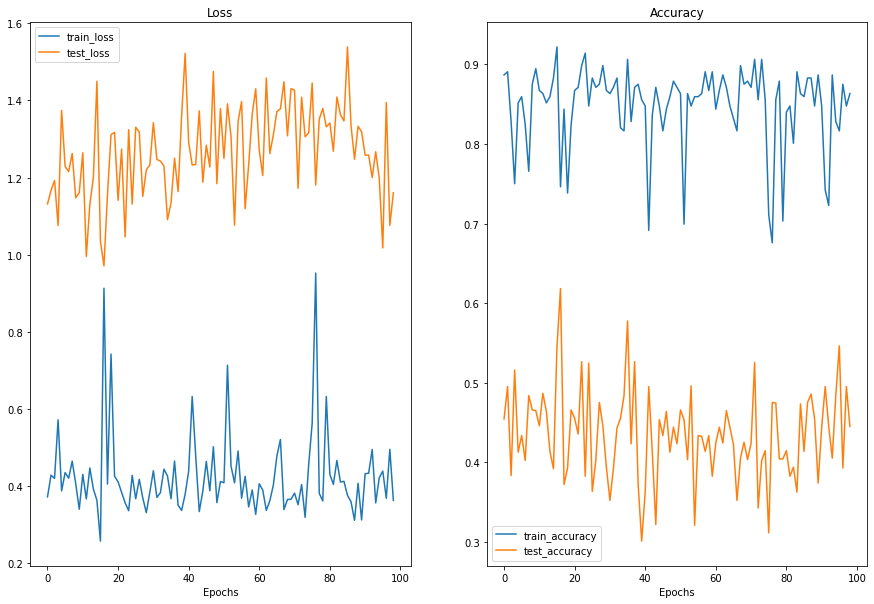

In [ ]:
plot_loss_curve(model_0_results)

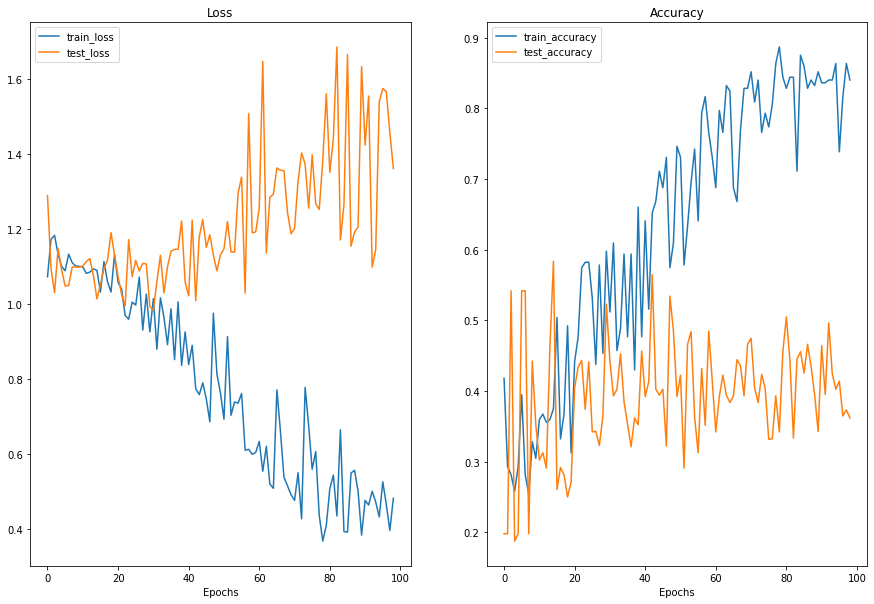

In [ ]:
plot_loss_curve(model_2_results)

# TinyVGG with Data Augmentation
Let's try another modelling experiment with some data augmentation

## Create data with augmentation

In [ ]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])
train_transform_trivial, test_transform_simple

## Create `datasets` and `dataloader` with data augmentation

In [ ]:
# Turn image folder into dataset
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)
train_data_augmented, test_data_simple

In [ ]:
# Turn datasets into dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)
train_dataloader_augmented, test_dataloader_simple

## Construct and train model 1

This time we will be using the same model architecture but with augmented data

In [ ]:
# Create model 1 and send it to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=16,
                  output_shape=len(train_data_augmented.classes),
                  resolution=64).to(device)
model_1

Wonderful! We have our model and dataloader, let's create `loss_fn` and `optimizer` to use on `train()` function to train and evaluate model 1

In [ ]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
EPOCH_NUM = 100

# Set up loss function
loss_fn = nn.CrossEntropyLoss()

# Set up optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.0001)

# Start timer
start_time = timer()

# Train model 1
model_1_results, model_1 = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=EPOCH_NUM,
                        device=device)

# End timer
end_time = timer()

print_train_time(start=start_time,end=end_time,device=device)

In [ ]:
!nvidia-smi


In [ ]:
plot_loss_curve(model_1_results)

## Compare model results
After evaluating modelling experiments on their own, it's important to compare them to each other

There's a few different way to do this:
1. Hard coding (What's we're doing)
2. Torch + TensorBoard
3. Weights and Biases
4. MLFlow

In [ ]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)


In [ ]:
# Setup a plot
epochs = 49
plt.figure(figsize=(15, 10))
# Get number of epochs
epochs = range(len(model_0_df)-2)
# Plot train loss
plt.subplot (2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"][2:], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"][2:], label="Model 1")
plt.title( "Train Loss") 
plt.xlabel("Epochs") 
plt.legend()
# Plot test loss
plt. subplot (2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"][2:], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"][2:], label="Model 1")
plt.title( "Test Loss") 
plt.xlabel("Epochs") 
plt.legend()
# Plot train accuracy
plt. subplot (2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"][2:], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"][2:], label="Model 1")
plt.title( "Train Accuracy") 
plt.xlabel("Epochs") 
plt.legend()
# Plot test accuracy
plt. subplot (2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"][2:], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"][2:], label="Model 1")
plt.title( "Test Accuracy") 
plt.xlabel("Epochs") 
plt.legend()